In [39]:
# Import Dependencies
import os
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress
from pprint import pprint
from sklearn.model_selection import train_test_split
import seaborn as sns

# File to load
spotify_df = pd.read_csv("Resources/Data Set under 100mb.csv")
spotify_df.head()

,name,popularity,duration_ms,explicit,artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Carve,6,126903,0,['Uli'],2/22/1922,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],6/1/1922,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],3/21/1922,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],3/21/1922,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,Lady of the Evening,0,163080,0,['Dick Haymes'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [40]:
# Spotify api claims any value above .66 is favored to be a podcast / book
# We will use any value below .66 as our classification of a song
music_df = spotify_df.drop(spotify_df[(spotify_df['speechiness'] >= .66)].index)
music_df.head()

,name,popularity,duration_ms,explicit,artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Carve,6,126903,0,['Uli'],2/22/1922,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.1510,0.1270,104.851,3
2,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],3/21/1922,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.2120,0.4570,130.418,5
3,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],3/21/1922,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.1040,0.3970,169.980,3
4,Lady of the Evening,0,163080,0,['Dick Haymes'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.3110,0.1960,103.220,4
5,Ave Maria,0,178933,0,['Dick Haymes'],1922,0.227,0.2610,5,-12.343,1,0.0382,0.994,0.2470,0.0977,0.0539,118.891,4


In [41]:
# create a clean year column for the data
music_df["release_date"] = pd.to_datetime(music_df["release_date"])
year = music_df["release_date"].dt.year
year.head()

0    1922
2    1922
3    1922
4    1922
5    1922
Name: release_date, dtype: int64

In [42]:
music_df = pd.DataFrame({"name" : music_df["name"],
                         "artists": music_df["artists"],
                         "popularity": music_df["popularity"],
                         "year" : year,
                         "danceability":music_df["danceability"],
                         "energy": music_df["energy"],
                         "loudness": music_df["loudness"],
                         "tempo": music_df["tempo"],
                         "valence": music_df["valence"],
                         "speechiness": music_df["speechiness"],
                         "acousticness": music_df["acousticness"],
                         "instrumentalness": music_df["instrumentalness"],
})
music_df = music_df.dropna()
music_df.head()

,name,artists,popularity,year,danceability,energy,loudness,tempo,valence,speechiness,acousticness,instrumentalness
0,Carve,['Uli'],6,1922,0.645,0.4450,-13.338,104.851,0.1270,0.4510,0.674,0.7440
2,Vivo para Quererte - Remasterizado,['Ignacio Corsini'],0,1922,0.434,0.1770,-21.180,130.418,0.4570,0.0512,0.994,0.0218
3,El Prisionero - Remasterizado,['Ignacio Corsini'],0,1922,0.321,0.0946,-27.961,169.980,0.3970,0.0504,0.995,0.9180
4,Lady of the Evening,['Dick Haymes'],0,1922,0.402,0.1580,-16.900,103.220,0.1960,0.0390,0.989,0.1300
5,Ave Maria,['Dick Haymes'],0,1922,0.227,0.2610,-12.343,118.891,0.0539,0.0382,0.994,0.2470


In [43]:
# Create a new artist DataFrame 
artists_df = pd.DataFrame({"artists": music_df["artists"],
                           "popularity": music_df["popularity"],
                           "year": year})
artists_df.head()

,artists,popularity,year
0,['Uli'],6.0,1922
2,['Ignacio Corsini'],0.0,1922
3,['Ignacio Corsini'],0.0,1922
4,['Dick Haymes'],0.0,1922
5,['Dick Haymes'],0.0,1922


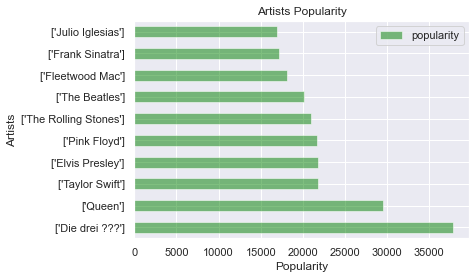

In [50]:
# Top 10 artists based on popularity value
Top10_artists = artists_df.groupby(['artists'])[['popularity']].sum().sort_values(by=['popularity'], ascending=False).head(10)
Top10_artists.plot.barh(color='green', alpha =0.5)
plt.title('Artists Popularity')
plt.xlabel('Popularity')
plt.ylabel('Artists')
plt.show()

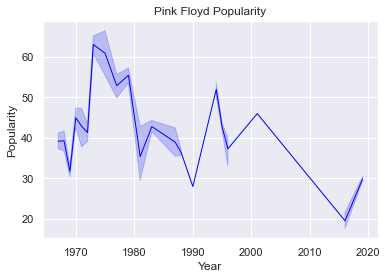

In [51]:
# The popularity of Pink Floyd songs over the year
pf = artists_df[artists_df['artists'] == "['Pink Floyd']"]
sns.set(style='darkgrid')
sns.lineplot(x='year', y='popularity',lw = 1, data=pf, color='blue')
plt.title("Pink Floyd Popularity")
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

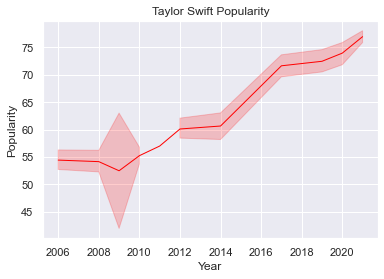

In [52]:
# The popularity of Taylor Swift songs over the year
ts = artists_df[artists_df['artists'] == "['Taylor Swift']"]
sns.set(style='darkgrid')
sns.lineplot(x='year', y='popularity',lw = 1, data=ts, color='red')
plt.title("Taylor Swift Popularity")
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()